# Build a basic chatbot

Install the prereuisit requirements

``` 
pip install -U langgraph
```


- `from typing import Annotated` and `from typing_extensions import TypedDict`:  
    These are used for type annotations. `TypedDict` lets you define a dictionary with specific keys and value types. `Annotated` allows you to add metadata to types.

- `from langgraph.graph import StateGraph, START` and `from langgraph.graph.message import add_messages`:  
    These import classes and functions from the `langgraph` library, which is used for building conversational AI workflows.

- `class State(TypedDict): ...`:  
    This defines a dictionary type called `State` with a single key, `messages`, which is a list. The `add_messages` annotation specifies that when updating this key, new messages should be appended to the list rather than replacing it.

- `graph_builder = StateGraph(State)`:  
    This creates a new state graph for managing the chatbot’s conversation state, using the `State` structure defined above.

In summary, this code sets up the data structure and graph logic needed to build a chatbot that tracks a list of messages in its state.

### Define StateGraph

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

### Define LLM

In [ ]:
from langchain_groq import ChatGroq 

llm = ChatGroq(temperature=0,
                    model_name="llama-3.3-70b-versatile",
                    api_key="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")


### Make Node

In [ ]:
def chatbot(state: State):
    response = llm.invoke(state["messages"])

    return {"messages": [response]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.add_edge(START, "chatbot")

In [ ]:
graph = graph_builder.compile()

### Display Graph

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Query to graph

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        # stream_graph_updates(user_input)
        print(graph.invoke({"messages": [{"role": "user", "content": user_input}]}))
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

# Add tools

```bash
pip install -U langchain-tavily

### Init tool

In [2]:
TAVILY_API_KEY = "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"
import os
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [9]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=1)

print(tool)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

max_results=1 api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))


{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'LangGraph From LangChain Explained In Simple Terms',
   'url': 'https://cobusgreyling.medium.com/langgraph-from-langchain-explained-in-simple-terms-f7cd0c12cdbf',
   'content': 'LangGraph is a method for creating state machines for conversational flow by defining them as graphs & it’s easier to understand than you might think. Prompt chaining can be described as a technique used in working with language models, where multiple prompts (nodes) are sequentially linked (via edges) together to guide the generative app through a series of related tasks or steps. LangGraph is a module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. Intro to LangGraph - LangGraph ------------------------------ ### Build language agents as graphs langchain-ai.github.io Building AI agent systems with LangGraph -------------------

### Init LLM

In [53]:
from langchain_groq import ChatGroq 

llm = ChatGroq(temperature=0,
                    model_name="llama-3.3-70b-versatile",
                    api_key="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")


### Define the graph

In [82]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

### Create a function to run the tools

In [84]:
import json

from langchain_core.messages import ToolMessage, HumanMessage, AIMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

### Crear Router Function

In [85]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

### Dispaly the graph

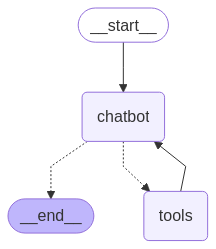

In [86]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Query to graph with tools

In [88]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "hello", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "HELLO | definition in the Cambridge English Dictionary", "url": "https://dictionary.cambridge.org/us/dictionary/english/hello", "content": "Meaning of hello in English Your browser doesn't support HTML5 audio Your browser doesn't support HTML5 audio You can also find related words, phrases, and synonyms in the topics: Grammar hello | Intermediate English Your browser doesn't support HTML5 audio Examples of hello Translations of hello Get a quick, free translation! Browse More meanings of hello Word of the Day fly in the face of something to completely oppose what seems sensible or normal Blog The pecking order: talking about how important people are (1) New Words advergame \u00a9 Cambridge University Press & Assessment 2025 To add hello to a word list please sign up or log in. Add hello to one of your lists below, or create a new one.", "score": 0.57322514, "raw_c

### Toos Call using prebuild function

In [89]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

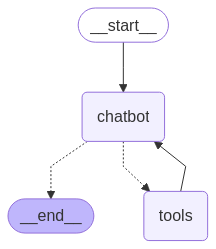

In [90]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass